This notebook uses the cleaned/wrangled metadata to continue exploring the Hsiao data. Specifically, the PCA looked kind of weird and I want to know what's up with it!

In [1]:
import pandas as pd
import numpy as np

import janitor as jn

from sklearn.decomposition import PCA

from skbio.diversity import beta_diversity
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

# Read in data

In [2]:
fotu = '../../data/clean/hsiao.dada2_otu_table.txt'
fmeta = '../../data/clean/hsiao.metadata.txt'

df = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)

In [3]:
print(df.shape, meta.shape)

((474, 2851), (474, 21))


In [4]:
# Calculate beta diversity
metric = 'braycurtis'
counts = df.astype(int).values
sample_ids = df.index.tolist()

results = beta_diversity(
    metric=metric,
    counts=counts,
    ids=sample_ids)

# PCA on all samples


In [5]:
pca_all = PCA(random_state=12345).fit(results.to_data_frame().values)
ypca_all = pca_all.transform(results.to_data_frame().values)

In [6]:
def make_toplot(ypca, samples, meta):
    """
    Make a dataframe with PC columns from ypca (numpy array).
    Merge meta (dataframe) on 'sample_id' with the samples in samples (list)
    """

    dfpca = pd.DataFrame(data=ypca, 
                         index=samples, 
                         columns=['PC' + str(i) for i in range(1, ypca.shape[1]+1)])
    
    dfpca = pd.merge(dfpca, meta, left_index=True, right_on='sample_id', how='left')

    return dfpca

In [7]:
dfpca_all = make_toplot(ypca_all, sample_ids, meta)
dfpca_all.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,diet_at_time_of_fecal_sample_collection_breast_milk,diet_at_time_of_fecal_sample_collection_formula,diet_at_time_of_fecal_sample_collection_solid_foods,diarrhoea_within_7_days_prior_to_sample_collection,antibiotics_within_7_days_prior_to_sample_collection,medications_antibiotics_and_other,sample_id,disease,raw_day,infection_progression
fecal_sampleid,,,,,,,,,,,,,,,,,,,,,
A.diarrhea.062,1.849497,1.012835,0.438005,0.444596,0.226847,0.522738,-0.454209,-0.319917,0.283175,-0.165698,...,NaN,NaN,NaN,NaN,NaN,NaN,A.diarrhea.062,diarrhea,62.0,0.6019417475728155
Bgsng7052.m26,-2.466575,-0.980531,0.093307,0.269557,0.519894,-0.273175,0.868652,-0.645804,-0.119983,-0.199703,...,Yes,No,Yes,No,No,NaN,Bgsng7052.m26,healthy,NaN,healthy
Bgsng7071.m32,-0.670900,1.228093,-0.165200,0.435669,-0.727463,-0.145395,0.553025,0.136191,0.038543,0.038253,...,Yes,No,Yes,No,No,NaN,Bgsng7071.m32,healthy,NaN,healthy
Bgsng7150.m36,-1.482100,-0.202321,-1.135984,-0.458558,-0.498394,0.410663,0.073262,-0.204143,-0.093217,-0.352476,...,Yes,No,Yes,No,No,Multi Vitamin,Bgsng7150.m36,healthy,NaN,healthy
Bgsng7192.m28,-2.141084,-1.649366,0.048020,-0.252762,0.150071,0.431590,-0.266952,-0.230986,0.175015,0.224965,...,Yes,No,Yes,No,No,NaN,Bgsng7192.m28,healthy,NaN,healthy


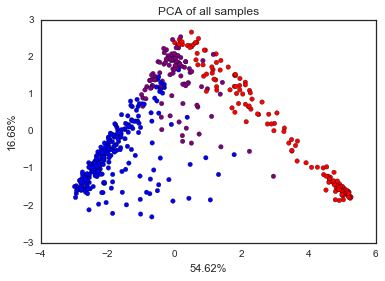

In [8]:
cdict = {'healthy': 'b', 'recovery': 'purple', 'diarrhea': 'r'}
dfpca_all['color'] = dfpca_all['disease'].apply(lambda x: cdict[x])
plt.scatter(dfpca_all['PC1'], dfpca_all['PC2'], c=dfpca_all['color'])
plt.title("PCA of all samples")
plt.xlabel('{:.2f}%'.format(pca_all.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_all.explained_variance_ratio_[1]*100))

In [45]:
# Number of samples
dfpca_all.groupby(['disease']).size()

disease
diarrhea    138
healthy     238
recovery     98
dtype: int64

In [43]:
# Number of subjects
dfpca_all.groupby(['disease', 'subject_id']).size().reset_index().groupby('disease').size()

disease
diarrhea     7
healthy     25
recovery     7
dtype: int64

Yep, okay still some weird batch effect happening here. Let's zoom in on the diarrhea/recovery samples.

# PCA on the recovery/diarrhea samples (group A)

In [9]:
a_group = meta['group_description'].str.startswith('a')
a_samples = meta.loc[a_group, 'sample_id'].values

pca_agroup = PCA(random_state=12345).fit(results.to_data_frame().loc[a_samples, a_samples].values)
ypca_agroup = pca_agroup.transform(results.to_data_frame().loc[a_samples, a_samples].values)

In [10]:
dfpca_agroup = make_toplot(ypca_agroup, a_samples, meta)

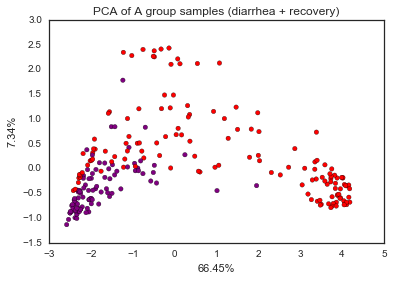

In [11]:
cdict = {'healthy': 'b', 'recovery': 'purple', 'diarrhea': 'r'}
dfpca_agroup['color'] = dfpca_agroup['disease'].apply(lambda x: cdict[x])
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], c=dfpca_agroup['color'])
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))

dark blue = first day of infection, white = last day of infection, red = last day of sampling


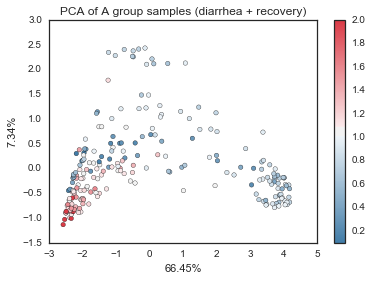

In [12]:
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], 
            c=dfpca_agroup['infection_progression'],
            cmap=sns.diverging_palette(240, 10, as_cmap=True, center='light'))
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))
plt.colorbar()
print('dark blue = first day of infection, white = last day of infection, red = last day of sampling')

dark blue = first day of infection, white = last day of infection, red = last day of sampling


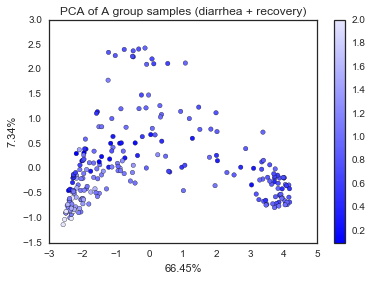

In [13]:
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], 
            c=dfpca_agroup['infection_progression'],
            cmap=sns.light_palette('blue', as_cmap=True, reverse=True))
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))
plt.colorbar()
print('dark blue = first day of infection, white = last day of infection, red = last day of sampling')

Doesn't really look like there's a temporal pattern here, apart from the recovery samples being in the bottom left. Perhaps subject-wise?

In [14]:
cdict = {i:j for i, j in zip(dfpca_agroup['subject_id'].unique(), sns.color_palette("Set1", len(dfpca_agroup['subject_id'].unique())))}
dfpca_agroup['subject_color'] = dfpca_agroup['subject_id'].apply(lambda x: cdict[x])

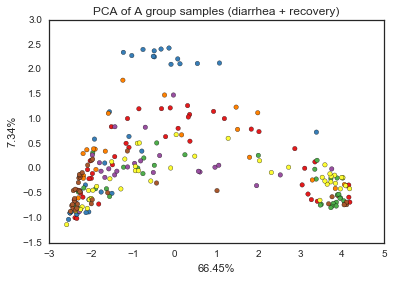

In [15]:
plt.scatter(dfpca_agroup['PC1'], dfpca_agroup['PC2'], 
            c=dfpca_agroup['subject_color'],
            cmap=sns.diverging_palette(240, 10, as_cmap=True))
plt.title("PCA of A group samples (diarrhea + recovery)")
plt.xlabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup.explained_variance_ratio_[1]*100))


Nope, not really here either... Why is the PCA plot so funny-shaped then??

Two options moving forward: what features correlate with PC1 (and are they driven by sparsity or something?). Also, if I do PCA within each patient, do I see a temporal trend there?

## What's going on with PC1?

In [16]:
ypca_agroup.shape

(236, 236)

In [17]:
df.loc[a_samples].shape

(236, 2851)

In [18]:
results.to_data_frame().shape

(474, 474)

Oh wait damn you can't do that bc these are PCoA's. Let's make a straight-up Euclidean PCA...?

# Normal PCA (not PCoA)

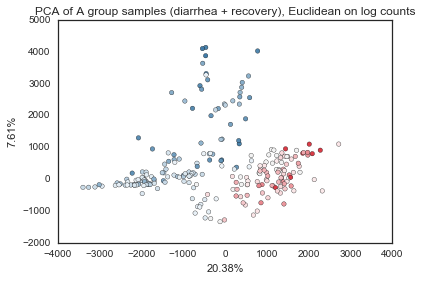

In [53]:
# Side note: the PCA plot looks fine if you log the counts
pca_agroup_euc = PCA(random_state=12345).fit(np.log10(df.loc[a_samples].values + 1))
ypca_agroup_euc = pca_agroup_euc.transform(df.loc[a_samples].values)
dfpca_agroup_euc = make_toplot(ypca_agroup_euc, a_samples, meta)
plt.scatter(dfpca_agroup_euc['PC1'], dfpca_agroup_euc['PC2'],
            c=dfpca_agroup['infection_progression'],
            cmap=sns.diverging_palette(240, 10, as_cmap=True, center='light'))
plt.title("PCA of A group samples (diarrhea + recovery), Euclidean on log counts")
plt.xlabel('{:.2f}%'.format(pca_agroup_euc.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup_euc.explained_variance_ratio_[1]*100))


In [54]:
pca_agroup_euc = PCA(random_state=12345).fit(df.loc[a_samples].values)
ypca_agroup_euc = pca_agroup_euc.transform(df.loc[a_samples].values)

In [55]:
dfpca_agroup_euc = make_toplot(ypca_agroup_euc, a_samples, meta)

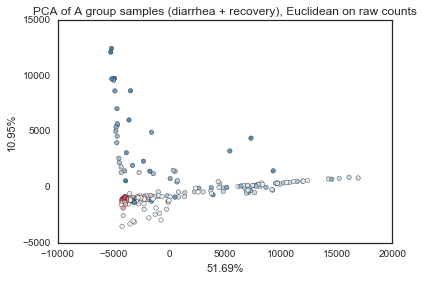

In [57]:
plt.scatter(dfpca_agroup_euc['PC1'], dfpca_agroup_euc['PC2'],
            c=dfpca_agroup['infection_progression'],
            cmap=sns.diverging_palette(240, 10, as_cmap=True, center='light'))
plt.title("PCA of A group samples (diarrhea + recovery), Euclidean on raw counts")
plt.xlabel('{:.2f}%'.format(pca_agroup_euc.explained_variance_ratio_[0]*100))
plt.ylabel('{:.2f}%'.format(pca_agroup_euc.explained_variance_ratio_[1]*100))


Ok this looks super crazy. *Now* what's in PC1?

In [22]:
pca_comps = pd.DataFrame(data=pca_agroup_euc.components_, 
                         index=['PC' + str(i) for i in range(1, pca_agroup_euc.components_.shape[0]+1)],
                         columns=df.columns)
pca_comps.head()

,bbe1b6abd7b8765bdb44601cea259ef0,c90c3a8c4950b89e6e285afa2c05b3e3,ddc7466d073c844eeb86db871e43f205,6bf1a63f1d1b1de9479fb487edb3c077,7e7a16ce216f4ed1d626e25a0f144911,bda9644fa1bec6c0e75cee105e869d42,dac5ca8f20f8291f145c1fd866681218,e6c455846421d3fddd93b1960f78ab08,de4489de0ed2c7a9a8f449164b335fea,e61ce464762adef827e605922b2946e5,...,eeacf6793e9c483cae7f48d295f0cf66,7a38d0bda720a66891722966f63cf6b7,cc9805d9b9ed24f88d0443a69f6029e6,af982c4332b8714c1e48a63ad9588ac7,0a7df920b573f927d17cbd067b9c6fd5,759fe850f2ce516d28a81d9022e64558,fdd1731a9695493c09fd0dac29c57940,19e05c133a36c8fad1b8aae68b8db0e2,29b43dab144ef0ad9c96b826c1af057a,93c8179db48df83d4d5f50e786a4fc3d
PC1,-0.014706,0.986021,-0.100231,0.021693,0.000234,-0.001340,-0.003238,-0.001783,0.000493,-0.000038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PC2,0.083840,0.081554,0.930399,-0.131916,-0.004380,0.010301,0.048667,0.011726,-0.000722,0.001425,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
PC3,-0.016905,0.033543,0.226835,0.245087,0.013382,-0.003639,0.016528,0.000064,0.005550,0.000328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PC4,0.056909,0.025774,-0.135194,-0.127286,-0.000122,0.017861,-0.022618,0.007507,0.000651,-0.000382,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PC5,-0.113441,0.003362,-0.125756,-0.028722,-0.000700,0.013347,-0.016906,0.008222,-0.000060,-0.000547,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Let's look at the first few PC's - are they driven predominantly by one or two OTUs? And if so, is there something weird about that OTU?

For the first 3 PC's, plot: the first 20 components, the average abundance across all A group samples, and the median abundance across all A group samples

(0, 'c90c3a8c4950b89e6e285afa2c05b3e3')
(1, 'ddc7466d073c844eeb86db871e43f205')
(2, '8c35682622c92dfd0ba4b9205c744d49')


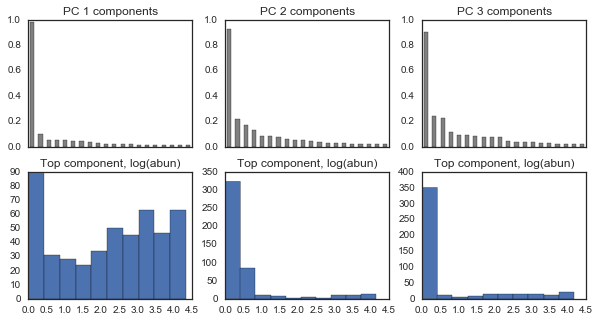

In [23]:
n_pcs = 3

fig, ax = plt.subplots(2, n_pcs, figsize=(10, 5))

for i in range(n_pcs):
    sorted_features = abs(pca_comps.loc['PC' + str(i + 1)]).sort_values(ascending=False)
    # Plot PC contribution
    sorted_features.head(20).plot(kind='bar', ax=ax[0, i], color='gray')
    # Get rid of x labels
    ax[0, i].set_xticklabels('')
    ax[0, i].set_title('PC ' + str(i + 1) + ' components')
    # Plot abundances
    ax[1, i].hist(np.log10(df[sorted_features.index[0]] + 1))
    ax[1, i].set_title('Top component, log(abun)')
    
    print(i, sorted_features.index[0])

So it looks like PC1 is dominated by one OTU that is zero in many people, but ranges up to 10,000 reads in others. Augh I guess I need to map the OTU to taxonomy to see what it is/whether I trust it...? Blerg.

Another option if I end up not trusting this data: normalize each patient to their own recovered abundances. Each person has multiple samples taken after infection, so maybe it would work?

# PCoA PC1 correlations

Look at the value of each sample's PC1 on the PCoA plot, and see if it correlates with any OTUs.

In [24]:
dfpca_agroup.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,diet_at_time_of_fecal_sample_collection_solid_foods,diarrhoea_within_7_days_prior_to_sample_collection,antibiotics_within_7_days_prior_to_sample_collection,medications_antibiotics_and_other,sample_id,disease,raw_day,infection_progression,color,subject_color
fecal_sampleid,,,,,,,,,,,,,,,,,,,,,
A.diarrhea.016,-2.017714,0.152791,1.814929,-0.639034,-0.135191,-0.231175,-0.623303,-0.510720,-0.072059,-0.525565,...,NaN,NaN,NaN,NaN,A.diarrhea.016,diarrhea,16.0,0.1553398058252427,r,"(0.8941176533699036, 0.10196078568696976, 0.10..."
A.diarrhea.020,-1.159835,0.505538,1.931917,-0.927138,-0.175743,0.240963,-0.582505,-0.601627,0.012659,-0.460422,...,NaN,NaN,NaN,NaN,A.diarrhea.020,diarrhea,20.0,0.1941747572815534,r,"(0.8941176533699036, 0.10196078568696976, 0.10..."
A.diarrhea.021,-1.431443,0.237672,1.447056,-0.901254,-0.277153,0.363800,-0.366415,-0.227498,0.244887,-0.408403,...,NaN,NaN,NaN,NaN,A.diarrhea.021,diarrhea,21.0,0.20388349514563106,r,"(0.8941176533699036, 0.10196078568696976, 0.10..."
A.diarrhea.024,3.047537,-0.332423,0.882941,-0.496891,-0.339368,0.055722,-0.298389,-0.245097,-0.208894,0.043147,...,NaN,NaN,NaN,NaN,A.diarrhea.024,diarrhea,24.0,0.23300970873786409,r,"(0.8941176533699036, 0.10196078568696976, 0.10..."
A.diarrhea.027,3.896305,-0.544270,0.499678,0.075252,-0.038660,-0.125573,-0.074992,-0.137821,-0.063166,0.091723,...,NaN,NaN,NaN,NaN,A.diarrhea.027,diarrhea,27.0,0.2621359223300971,r,"(0.8941176533699036, 0.10196078568696976, 0.10..."


In [25]:
from scipy.stats import spearmanr

samples = dfpca_agroup.index

In [26]:
reslst = []
for o in df.columns:
    r, p = spearmanr(dfpca_agroup['PC1'], df.loc[samples, o])
    reslst.append([o, r, p])


/Users/claire/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/claire/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [27]:
corrdf = pd.DataFrame(data=reslst, columns=['otu', 'spearman_r', 'p'])

In [28]:
corrdf['abs_r'] = abs(corrdf['spearman_r'])
corrdf.sort_values(by='abs_r', ascending=False).head()

,otu,spearman_r,p,abs_r
1,c90c3a8c4950b89e6e285afa2c05b3e3,0.946609,5.006333e-117,0.946609
357,93e1c76e3803548847aa874029b4c520,-0.652481,5.203577e-30,0.652481
338,9dec20c10726a23dc244ff09c981c8a4,-0.626484,3.922479e-27,0.626484
670,46803c5d27e41c9abf6620c770fde0e7,-0.623391,8.279299e-27,0.623391
138,a0c6cdece598855bb996d3128e2fe733,-0.622465,1.033614e-26,0.622465


In [29]:
'c90c3a8c4950b89e6e285afa2c05b3e3' == corrdf.sort_values(by='abs_r', ascending=False)['otu'].iloc[0]

True

So the OTU that correlates with PC1 in the PCoA plot is the same as the one driving PC1 in the Euclidean PCA plot. Next up: is this cholera?!

Note: I'm not actually sure that I expect it to be cholera. If it were cholera, I'd expect more of a temporal trend along PC1. How will I know if it's a contamination...?

## zomg what bug is that OTU?

In [30]:
ftax = '../../data/raw/hsiao/qiime/hsiao_export/hsiao.taxonomy.tsv'
tax = pd.read_csv(ftax, sep='\t')
tax = jn.clean_names(tax)
tax.head()

,feature_id,taxon,confidence
0,40e6618c26d0dbb593dca4c5e7e8143d,Unassigned,0.335648
1,d5bf21e92f9007e07c5da8599d3d9b05,D_0__Bacteria;D_1__Firmicutes;D_2__Bacilli;D_3...,0.963722
2,4c2151ac3c79da23ef14d9e8fc41c530,Unassigned,0.310011
3,6a7e107e60318e7a1fb9c9f1b2140dd3,D_0__Bacteria;D_1__Proteobacteria;D_2__Gammapr...,0.999708
4,22e19f1839f7c3addef6523459c7ceb6,D_0__Bacteria;D_1__Firmicutes;D_2__Clostridia;...,0.979240


In [31]:
o = 'c90c3a8c4950b89e6e285afa2c05b3e3'

tax.query('feature_id == @o')

,feature_id,taxon,confidence
994,c90c3a8c4950b89e6e285afa2c05b3e3,D_0__Bacteria;D_1__Firmicutes;D_2__Bacilli;D_3...,0.999918


In [32]:
tax.query('feature_id == @o')['taxon'].values

array(['D_0__Bacteria;D_1__Firmicutes;D_2__Bacilli;D_3__Lactobacillales;D_4__Streptococcaceae;D_5__Streptococcus'],
      dtype=object)

Hm. Not cholera. Not sure what to make of it, tbh. Maybe blast it?

Or how about we look at its abundance in each patient?

In [33]:
strep = df[o]
strep = strep.reset_index()
strep = strep.rename(columns={'index': 'sample_id'})
strep = pd.merge(strep, meta)

keep_dis = ['diarrhea', 'recovery']
strep = strep.query('disease == @keep_dis').dropna(how='all', axis=1)
strep.head()

,sample_id,c90c3a8c4950b89e6e285afa2c05b3e3,subject_id,fecal_sampleid.1,barcode_sequence,number_of_v4_16s_rrna_sequences,group_description,sampleid_description,disease,raw_day,infection_progression
0,A.diarrhea.062,2709.0,A,A.diarrhea.062,CACTGAGTACGT,111924,a. Human fecal cholera study V4-16S rRNA seque...,* SubjectID.Study Phase.Sample Number,diarrhea,62.0,0.6019417475728155
5,G.recovery.d003,6677.0,G,G.recovery.d003,CAAATGGTCGTC,128210,a. Human fecal cholera study V4-16S rRNA seque...,* SubjectID.Study Phase.Sample Number,recovery,31.0,1.0348837209302326
7,G.diarrhea.026,13729.0,G,G.diarrhea.026,GAAACGGAAACG,102001,a. Human fecal cholera study V4-16S rRNA seque...,* SubjectID.Study Phase.Sample Number,diarrhea,26.0,0.9285714285714286
8,G.recovery.d037,9.0,G,G.recovery.d037,TGACGCCTCCAA,121884,a. Human fecal cholera study V4-16S rRNA seque...,* SubjectID.Study Phase.Sample Number,recovery,65.0,1.4302325581395348
9,A.diarrhea.098,2252.0,A,A.diarrhea.098,CAAACTGCGTTG,123277,a. Human fecal cholera study V4-16S rRNA seque...,* SubjectID.Study Phase.Sample Number,diarrhea,98.0,0.9514563106796117



y-axis = raw counts
x-axis = sample number


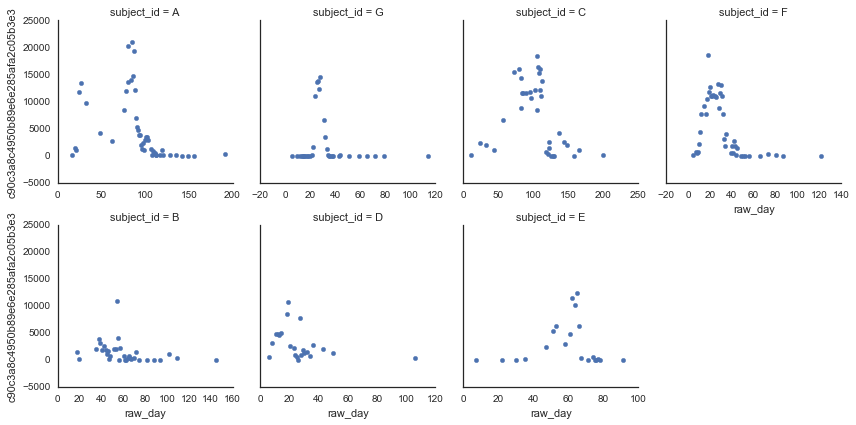

In [34]:
g = sns.FacetGrid(data=strep, col='subject_id', col_wrap=4, sharex=False)
g.map(plt.scatter, 'raw_day', o)
print('\ny-axis = raw counts\nx-axis = sample number')


y-axis = raw counts
x-axis = infection progression (1 = last day of diarrhea)


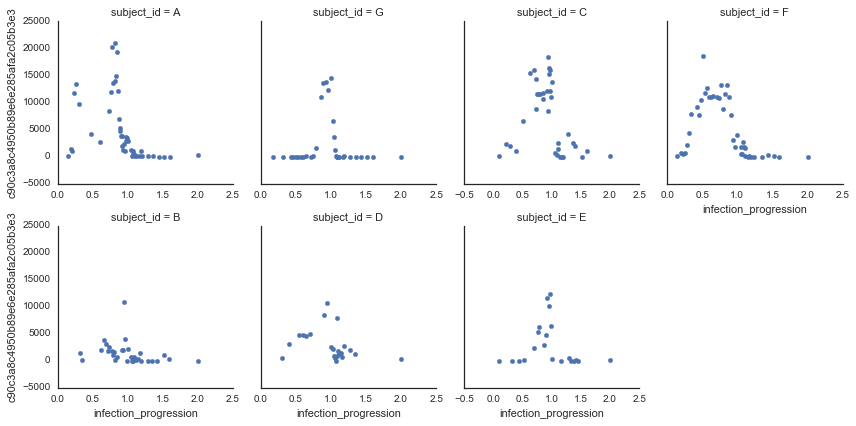

In [35]:
g = sns.FacetGrid(data=strep, col='subject_id', col_wrap=4, sharex=False)
g.map(plt.scatter, 'infection_progression', o)
print('\ny-axis = raw counts\nx-axis = infection progression (1 = last day of diarrhea)')

## One more check: relative abundance of this bug?

In [36]:
abundf = df.divide(df.sum(axis=1), axis=0)

strep_abun = abundf[o]
strep_abun = strep_abun.reset_index()
strep_abun = strep_abun.rename(columns={'index': 'sample_id'})
strep_abun = pd.merge(strep_abun, meta)

keep_dis = ['diarrhea', 'recovery']
strep_abun = strep_abun.query('disease == @keep_dis').dropna(how='all', axis=1)


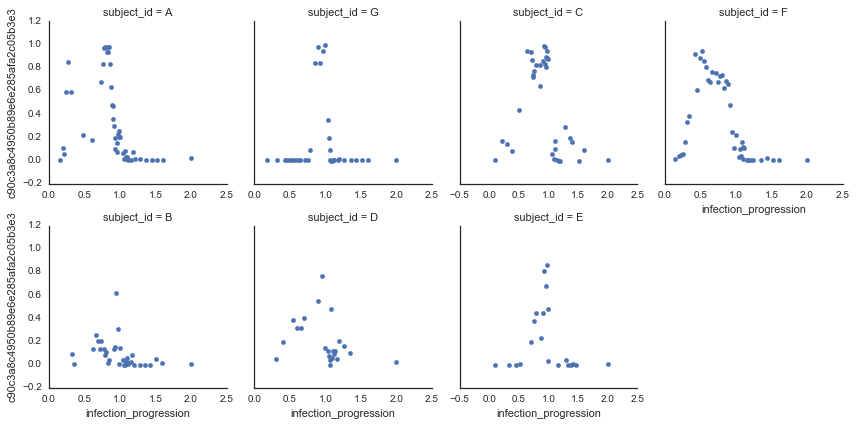

In [37]:
g = sns.FacetGrid(data=strep_abun, col='subject_id', col_wrap=4, sharex=False)
g.map(plt.scatter, 'infection_progression', o)

Hm. Either these samples were processed very batchily, or this is a weird OTU that super-blooms during infection and then goes back way down. SO WEIRD. I think I'm gonna BLAST it.

In [38]:
o

'c90c3a8c4950b89e6e285afa2c05b3e3'

Get the sequence from the fasta:

```
22:39-claire:~/github/donor-selection/data/raw/hsiao/qiime/hsiao_export$ grep -A 2 c90c3a8c4950b89e6e285afa2c05b3e3 hsiao.dna-sequences.fasta
>c90c3a8c4950b89e6e285afa2c05b3e3
TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTAATAAGTCTGAAGTTAAAGGCAGTGGCTTAACCATTGTTCGCTTTGGAAACTGTTAGACTTGAGTGCAGAAGGGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGATATATGGAGGAACACCGGTGGCGAAAGCGG
```

Then I [BLAST it](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=E1N5JGSZ01R), and it looks like it's either *Streptococcus equinus* or *Streptococcus lutetiensis*. Who are these bugs and what do they have to do with cholera?

From [Wikipedia](https://en.wikipedia.org/wiki/Streptococcus_equinus), looks like *S. equinus* is a horse bug. Wikipedia says "S. equinus is seldom found in humans." 

Looks like S. lutetiensis might be human-associated? [This paper](http://jcm.asm.org/content/51/12/4259.full) reports it isolated in a case of bacteremia. Ugh this is annoying it's one of those taxonomy fights. From [bacterio.net](http://www.bacterio.net/streptococcus.html): "Streptococcus infantarius subsp. lutetiensis". Okay, but it definitely does seem to be human-associated ([ref](http://www.tgw1916.net/Streptococcus/lutetiensis.html)).

Wait! [This paper](https://bmcmicrobiol.biomedcentral.com/articles/10.1186/1471-2180-13-141) seems to have found it too! `Dynamics of fecal microbial communities in children with diarrhea of unknown etiology and genomic analysis of associated Streptococcus lutetiensis`

I wonder if Strep comes out in my diarrhea studies too?!\

If I just Google Scholar "lutetiensis" I get lots of things related to bacteremia. Also [one paper](https://gutpathogens.biomedcentral.com/articles/10.1186/s13099-015-0074-0) about infectious endocarditis (IE). Looks like this is a nasty bug... Also in Kedong sufu (Chinese fermented soy food), lol: https://onlinelibrary.wiley.com/doi/abs/10.1002/jsfa.5918

More diarrhea studies:

- http://www.ebiomedicine.com/article/S2352-3964(15)30251-6/fulltext    
- not about the bug itself, but might be useful for context: https://onlinelibrary-wiley-com.libproxy.mit.edu/doi/pdf/10.1111/1462-2920.13873    
- https://www.sciencedirect.com/science/article/pii/S0264410X1730659X#b0320    

TODO: find the GEMS study and see if it's in there.

Next steps:

- figure out if S. lutetiensis consistently has this behavior in other diarrhea time series datasets (but to what end?)   
- try to identify bugs associated with recovery? But then what? (The paper found 260 species associated with diarrhea/recovery phases. They used indicator analysis).    
- correlate bugs, then find clusters that are associated with recovery/diarrhea? (Like in Lawrence's paper)    
- build classifier to distinguish diarrhea vs. recovery and score OB donors on that (but only seven subjects in this paper, do I really expect this classifier to generalize?)     